# PS88 Replication (Ritter and Conrad)

A Challenge of working with the Ritter and Conrad paper is that there is tons of data: since they look at individual provinces and individual days, there are nearly 7 million observations. 

By default we can only have 1GB in memory in datahub, which is less than the full data file. So we will need to play some tricks. 

A lot of what we will do here is explore some ways to look at smaller slices and aggregations of the data, hopefully learning some things along the way.

In [1]:
import pandas as pd
import seaborn as sns

# Part 1 Exploration by year and country

First we will read in a dataframe that has all 6.8 million observations, but only contains the year the observation correspond to and the two main variables: the count of dissent events and the count of repression events.

Note there are lots of obesrvations for each year, each corresponding to different regions/day, but I left that out so it doesn't overwhelm the memory of the notebook.

In [2]:
ydr = pd.read_csv("https://berkeley.box.com/shared/static/2lzex61lm8irfqfwyffqb8vgalo7uj2p.csv")
ydr

,year,dissentcount,represscount
0,1990,0,0
1,1990,0,0
2,1990,0,0
3,1990,0,0
4,1990,0,0
...,...,...,...
6809570,2012,0,0
6809571,2012,0,0
6809572,2012,0,0
6809573,2012,0,0


Let's use `value_counts()` to make a frequency table which tells us how often there is dissent in a region-day observation.

In [6]:
ydr['dissentcount'].value_counts()

0    6792800
1      13715
2       2894
3        138
4         26
5          2
Name: dissentcount, dtype: int64

As we can see, in the vast majority of cases they do not detect any dissent in a given region/day. 

**Question 1.1. Use `value_counts` to make a frequency table of counts of repression in each region/day**

How often is there dissent and repression in a region/day? To see this bivariate relationship with out making a huge table, let's just check how often there is at least one event of each kind:

In [9]:
pd.crosstab(ydr['dissentcount']>0, ydr['represscount']>0)

represscount,False,True
dissentcount,,
False,6781560,11240
True,12123,4652


Another way to see this is as a proportion of all observations:

In [10]:
pd.crosstab(ydr['dissentcount']>0, ydr['represscount']>0)/6809575

represscount,False,True
dissentcount,,
False,0.995886,0.001651
True,0.001780,0.000683


So, 99.6% of observations have no repression or dissent, and less than .01% have both.

We can compute the average repressive events in a region/day using the `groupby` function. The syntax is a bit goofy. The line of code `df.groupby(groupvar, as_index=False)['summaryvar'].summarystat()` gives us the `summarystat` of `summaryvar` by `groupvar`. (The `as_index=False` puts the output as a dataframe, which will be useful for what we do next).

For example, the following gives the mean of `represscount` by `year`.

In [11]:
repressyr = ydr.groupby('year', as_index=False)['represscount'].mean()
repressyr

,year,represscount
0,1990,0.001345
1,1991,0.002958
2,1992,0.004379
3,1993,0.003209
4,1994,0.003903
5,1995,0.002792
6,1996,0.004112
7,1997,0.004854
8,1998,0.003927
9,1999,0.003172


One thing we can see here is that there is no data beyond 2009 though that paper says they have data from 1990-2012. (I'm pretty sure this isn't due to a mistake in merging on our part.) Not a huge deal though.

**Question 1.2 Create a dataframe called `dissentyr` which computes the average of `dissentcount` by year.**

Now we can put these together in one data frame.

In [13]:
dissentyr['represscount'] = repressyr['represscount']

We can plot the trends of repression and dissent over time with `sns.lineplot`.

<AxesSubplot:xlabel='year', ylabel='dissentcount'>

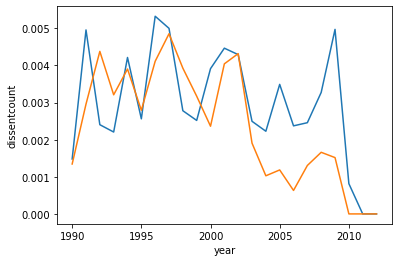

In [14]:
sns.lineplot(x="year", y="dissentcount", data=dissentyr)
sns.lineplot(x="year", y="represscount", data=dissentyr)

It looks like these tend to go up and down together. 

**Question 1.3. Use `sns.scatterplot` to make a graph with yearly average dissent on the x axis and yearly average repression on the y axis.**

At least in aggregate, there is a strong relationship between these variables.

To limit how much memory we are using, we can use the %reset command to delete everything stored in memory. This will give you a warning message, type y.

After doing this we need to reload the libraries we are using

In [17]:
import pandas as pd
import seaborn as sns

Now let's load in a dataframe that includes the country variable (called `adm0_name`) and our key variables.

In [18]:
cdr = pd.read_csv("https://berkeley.box.com/shared/static/gebfvyi6zxghj766hj72aeu5tdk7q291.csv")
cdr

,adm0_name,dissentcount,represscount
0,Algeria,0,0
1,Algeria,0,0
2,Algeria,0,0
3,Algeria,0,0
4,Algeria,0,0
...,...,...,...
6809570,Ilemi triangle,0,0
6809571,Ilemi triangle,0,0
6809572,Ilemi triangle,0,0
6809573,Ilemi triangle,0,0


**Question 1.4 Use the `groupby` function to compute the average levels of repression and dissent by country, and then put these together in a single data frame.**

**Question 1.5. Use `sns.regplot` to make a scatter plot with average dissent by country on the x axis and average repression by country on the y axis, with a best fit line. Describe what you find.**

## Part 2: Replication(ish)

Now let's move on to replicating the main table. Unfortunately there are too many observations to do this easily on datahub.

A natural way to deal with this, particularly with a large data set, would be to take a random sample of all observations. With 6.8 million observations, even a 1% sample would leve us with 68,000 or so observations, which is a lot!

However, recall the first thing we did with the full dataset was count how many instances there were with `dissentcount > 0` and `represscount > 0`. There were only about 4600 cases with repression and dissent, and so with a 1% sample we will be down to about 46 cases of both. It will be hard to make strong inferences here, (particularly since, as we will see, the relationship between rainfall and dissent is not very strong).

Another alternative, which isn't perfect, is to keep all cases of some dissent, and then a random sample of the cases with no repression. As we will see, this will lead to pretty similar results to what the paper has.

The data set we load up after our libraries contains all the cases with dissent, and 100,000 randomly chosen ones with no dissent. This gets the data frame down to a very manageable size

In [1]:
import pandas as pd
import seaborn as sns
from linearmodels.iv import IV2SLS
import statsmodels.formula.api as smf 

In [2]:
rc_samp = pd.read_csv("rc_samp0.csv")

Since we are working with a sample, the results won't exactly match the paper. Here is a version of columns 1-4 of table 1 from the paper on this sample. Like in the paper, each cell gives the coefficient on the variable in question, and the standard error in parenthesis. The key thing that you'll want to check matches are the coefficients on the different variables. 

|                   | OLS (no instrument)                               | IV Regression  | IV (Autocracies) | IV (Democracies) |
| ----------------- | ------------------------------------------------- | -------------- | ---------------- | ---------------- |
|                   | *Second Stage: The Effect of Dissent on Repression* |
| Mobilized Dissent | 0.2336 (.001)                                      | \-0.0708 (.071) | .0086 (.041)      | .2473 (.033)      |
| Urbanization      | 0.0324 (.010)                                      | \-0.0738 (.027) | \-.0315 (.019)    | \-.0062 (.015)    |
| Constant          | 0.0012 (.001)                                     | 0.059 (.014)   | .0472 (.211)      | \-.0092 (.006)    |
|                   | *First Stage: Instrumenting Mobilized Dissent*      |
| Rainfall (ln)     |                                                   | \-0.0083 (.001) | \-.0176 (.001)    | .0248 (.003)      |
| Annual Rainfall   |                                                   | 1.3367 (.208)   | 1.7708 (.230)     | \-.9161 (.503)    |
| Urbanization      |                                                   | \-.3551 (.028)  | \-.4000 (.034)    | \-.2628 (.044     |
| Constant          |                                                   | .1876 (.002)    | .1937 (.002)      | .1687 (.003)      |
|                   |                                                   |                |                  |                  |
| N                 | 107009                                            | 105438         | 83814            | 21502            |

**Question 2.1. Replicate column 1 of this table, by using `smf.ols` to run a regression with the count of repressive events (`represscount`) as the dependent variable, and the count of dissent events (`dissentcount`) and urbanization (`urban_mean`) as independent variables.**

Now let's move on to the instrumental variables regression in column 2. We'll work our way up, first computing the first stage.

**Question 2.2. Replicate the first stage of the regression in column 2, by using `smf.ols` to run a regression with the count of dissent events as the dependent variable, and the natural log of rainfall (`lograin`), the amount of rain as a percent of annual rainfall (`rainannualpct`), and urbanization as independent variables.**

**Question 2.3. Now replicate the second stage with `IV2SLS.from_formula`. Recall the general syntax here is `IV2SLS.from_formula("DV ~ 1 + CONTROLS + [IV ~ INSTRUMENTS]", data=df").fit().summary` where `DV` is the dependent variable, `CONTROLS` are the control variables that go in both the first and second stage, `IV` is the key independent variable, and `INSTRUMENTS` are the instruments. As a hint, there is one variable to use for `CONTROLS` and two variables to use for `INSTRUMENTS`, so enter those as `INSTRUMENT1 + INSTRUMENT2`. You might get some red "warnings" about missing data, which you can ignore.** 

**Question 2.4 [OPTIONAL]. Now replicate columns 3 and 4 by running the same first and second stage regressions, but with a sample of observations where the democracy variable is less than 0  (`latent_democracy < 0`) and then greater than 0 (`latent_democracy > 0`)**

## Part 3: In the year 2000

Another way to cut back on the size of the data file, which also can provide some different insights, is to restrict attention to a smaller time window. Here are the relevant variables for our replication just for the year 2000. This alone gets us over 300,000 observations.

In [8]:
rc2k = pd.read_csv("https://berkeley.box.com/shared/static/2mta14zoopm547uqr3ear2pvokfwzeaz.csv")
rc2k

,adm0_name,date,urban_mean,rainannualpct,latent_democracy,dissentcount,represscount,lograin
0,Algeria,2000-01-01,0.0,0.001779,-0.184923,0.0,0.0,-2.000409
1,Algeria,2000-01-02,0.0,0.006390,-0.184923,0.0,0.0,-0.721835
2,Algeria,2000-01-03,0.0,0.000000,-0.184923,0.0,0.0,0.000000
3,Algeria,2000-01-04,0.0,0.000756,-0.184923,0.0,0.0,-2.856666
4,Algeria,2000-01-05,0.0,0.000000,-0.184923,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
305756,NaN,NaN,NaN,NaN,1.992063,NaN,NaN,NaN
305757,NaN,NaN,NaN,NaN,1.993914,NaN,NaN,NaN
305758,NaN,NaN,NaN,NaN,0.701200,NaN,NaN,NaN
305759,NaN,NaN,NaN,NaN,0.906322,NaN,NaN,NaN


**Question 3.1. Run the same "column 1" regression that you did in 2.1, but with the year 2000 data. (Note: you can peek below for a table which contains the results of such regressions for 1990-2009 to check that you are getting the right coefficient on `dissentcount`.)**

**Question 3.2. Now use `smf.ols` to run the first stage of the column 2 regression.**

Note the coefficients are much closer to zero than they were on the sample we used in part 2 (though not far from the coefficients in the full sample reported in the paper). To get a sense of the magnitude here and see the relationship between our two instruments, let's look at a scatterplot of `lograin` and `rainannualpct`.

<AxesSubplot:xlabel='lograin', ylabel='rainannualpct'>

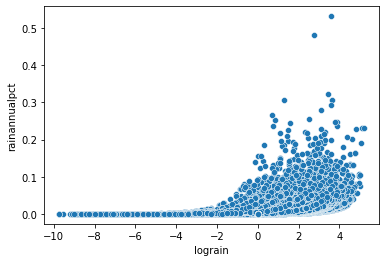

In [19]:
sns.scatterplot(x='lograin', y='rainannualpct', data=rc2k)

The range of range of `rainannualpct` is about 0 to .5 (it's rare to get half of the rain received in a year in one day!). Your coefficient on this should be about .025, so going from the least to most rain by this measure only leads to a predicted increase of .01 dissent events, which is pretty tiny. The prediction using `lograin` is about the same. Again there are no absolute rules here, but this likely violates the "strong first stage" requirement for doing IV. Still, we can do it and see what happens. 

**Question 3.3. Use `IV2SLS.from_formula` to run the "column 2" instrumental variables regression. (Again, you can peek at the table introduced below to check that you get the right coefficient on `dissentcount`.)**

Of course, picking out the year 2000 is a bit arbitrary. Using the wonders of loops, I ran all the OLS and instrument variables regressions for each of the year 1990 and 2009 and stored the coefficient on `dissentcount` in a table we'll import here:

In [21]:
yearsum = pd.read_csv("https://berkeley.box.com/shared/static/67025yl413c7v52wz8ke1mlkkjl2o44z.csv")

In [22]:
yearsum

,year,ols,iv2,iv3a,iv3b
0,1990,0.233365,0.871695,0.865586,0.500000
1,1991,0.308271,1.663010,1.565629,-0.001998
2,1992,0.187126,-1.565713,-1.441325,1.727623
3,1993,0.242019,-3.093142,-3.224883,-0.202748
4,1994,0.181689,0.506063,-0.459237,0.007059
5,1995,0.109637,0.040765,0.092316,0.006474
6,1996,0.092666,-0.125166,-0.102326,0.069215
7,1997,0.274846,-0.510579,-0.593200,-0.255912
8,1998,0.276135,-0.264156,-0.129264,0.294247
9,1999,0.085099,0.500007,0.641422,-3.224808


**Question 3.4. Use two calls of `sns.lineplot` to plot the OLS estimate of the effect of dissent on repression and the IV ("column 2") estimate of this effect as a function of the year**

What you should get is a relatively smooth line corresponding to the OLS estimate, and a very volatile one corresponding to the IV estimates. The takeaway here is that even we we have data on every region of a continent, and data by day, the relationship between rainfall and dissent is not strong enough to reliably use as an instrument. The original paper pools across about 20 years, which is enough to find a reasonably strong "first stage" estimate, but the fact that we need nearly 7 million data points for this is a bit worrying.